# Загрузка необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn import model_selection as model_selection

# Импортируем датасеты из csv-файлов:

# Данные по смертности из-зи загрязнения воздушной среды
air_data = pd.read_csv('data/death-rates-from-air-pollution.csv')

# Данные по континентальной принадлежности
country_data = pd.read_csv('data/countries.csv')

# Данные по ВВП
industry_index = pd.read_csv('data/VVP111.csv', sep=',')

air_data.head()

,Entity,Code,Year,"Air pollution (total) (deaths per 100,000)","Indoor air pollution (deaths per 100,000)","Outdoor particulate matter (deaths per 100,000)","Outdoor ozone pollution (deaths per 100,000)"
0,Afghanistan,AFG,1990,299.477309,250.362910,46.446589,5.616442
1,Afghanistan,AFG,1991,291.277967,242.575125,46.033841,5.603960
2,Afghanistan,AFG,1992,278.963056,232.043878,44.243766,5.611822
3,Afghanistan,AFG,1993,278.790815,231.648134,44.440148,5.655266
4,Afghanistan,AFG,1994,287.162923,238.837177,45.594328,5.718922


In [2]:
# Копируем данные
air_data_copy = air_data.copy()
country_data_copy = country_data.copy()
industry_index_copy = industry_index.copy()

In [3]:
# Преобразуем данные по ВВП в рассматриваемых странах
industry_index.head()

,Country Name,"""Country Code""","""Indicator Name""","""Indicator Code""","""1960""","""1961""","""1962""","""1963""","""1964""","""1965""",...,"""2014""","""2015""","""2016""","""2017""","""2018""","""2019""","""2020""","""2021""","""2022""",Unnamed: 67
0,Aruba,"""ABW""","""GDP (current US$)""","""NY.GDP.MKTP.CD""","""""","""""","""""","""""","""""","""""",...,"""2791061452.51397""","""2963128491.62011""","""2983798882.68156""","""3092178770.94972""","""3276187709.49721""","""3395793854.7486""","""2610038938.54749""","""3126019385.47486""","""""",NaN
1,Africa Eastern and Southern,"""AFE""","""GDP (current US$)""","""NY.GDP.MKTP.CD""","""21125015452.1973""","""21616228139.0375""","""23506279899.9665""","""28048360188.2788""","""25920665259.89""","""29472103269.7419""",...,"""1006526390112.83""","""927348469903.115""","""885176429223.509""","""1021043200767.01""","""1007196197587.41""","""1000834077088.55""","""927593321647.664""","""1081998139192.47""","""1169483734191.46""",NaN
2,Afghanistan,"""AFG""","""GDP (current US$)""","""NY.GDP.MKTP.CD""","""537777811.111111""","""548888895.555556""","""546666677.777778""","""751111191.111111""","""800000044.444444""","""1006666637.77778""",...,"""20550582746.8448""","""19998143635.873""","""18019554403.4503""","""18896353155.8839""","""18418860354.4238""","""18904502222.2108""","""20143451705.7548""","""14583135236.5744""","""""",NaN
3,Africa Western and Central,"""AFW""","""GDP (current US$)""","""NY.GDP.MKTP.CD""","""10447637852.9182""","""11173212080.394""","""11990534017.873""","""12727688165.4505""","""13898109284.018""","""14929792387.5151""",...,"""894322482190.281""","""768644740597.116""","""691363412188.46""","""684898755570.717""","""767025741475.038""","""822538393591.447""","""786460035395.026""","""844459722152.991""","""877863284874.068""",NaN
4,Angola,"""AGO""","""GDP (current US$)""","""NY.GDP.MKTP.CD""","""""","""""","""""","""""","""""","""""",...,"""137244439121.374""","""87219300384.5072""","""49840491178.1518""","""68972769395.6274""","""77792944471.9494""","""69309110145.7687""","""50241368243.6314""","""65685435100.4986""","""106713618735.434""",NaN


In [4]:
# удалим ненужные колонки
industry_index_copy = industry_index_copy.drop(industry_index_copy.columns[3], axis=1)
industry_index_copy = industry_index_copy.drop(industry_index_copy.columns[-1], axis=1)
industry_index_copy = industry_index_copy.drop(industry_index_copy.columns[2], axis=1)


def char_replace(value):
    """функция замены двух двойных кавычек в ячейке на 0 и удаления одинарных кавычек

    Args:
        value (str): передаваемая в функцию строка

    Returns:
        str: очищенная строка
    """
    return value.replace("\"\"", "0").replace('"', '')
    
    
# удалим из ячеек кавычки
industry_index_copy = industry_index_copy.applymap(char_replace)


# преобразуем столбцы в числовые
for idx, column in enumerate(industry_index_copy.columns):
    if idx > 1 and industry_index_copy[column].dtype == 'object':
        try:
            industry_index_copy[column] = industry_index_copy[column].astype('Float64')
            # industry_index_copy[column] = pd.to_numeric(industry_index_copy[column])
        except ValueError as e:
            print(f"Произошла ошибка при преобразовании столбца {column}: {e}")
            

# удалим из названий столбцов кавычки и пробелы по краям названий столбцов
industry_index_copy.rename(columns=lambda x: x.replace('"', ''), inplace=True)
industry_index_copy.rename(columns=lambda x: x.strip(), inplace=True)


industry_index_copy_T = industry_index_copy.T

# industry_country_codes = pd.DataFrame(industry_index_copy_T.iloc[1])


# создадим результирующую таблицу с ВВП по годам каждой страны
result_vvp_table = pd.DataFrame()
for column in industry_index_copy_T:   
    temp = industry_index_copy_T[[column]]
    temp['year'] = temp.index
    temp['code'] = temp.iloc[1,0]
    temp.reset_index(drop=True,inplace=True)
    temp.rename(columns={temp.columns[0]: 'value, $mils'},inplace=True)
    temp.drop([0,1], inplace=True)
    temp.reset_index(drop=True,inplace=True)
    result_vvp_table = pd.concat([result_vvp_table, temp], ignore_index=True)
    
result_vvp_table['year'] = result_vvp_table['year'].astype('int64')
result_vvp_table['code'] = result_vvp_table['code'].str.strip()

# приведем значение ВВП к миллионам для удобства
result_vvp_table['value, $mils'] = pd.to_numeric(result_vvp_table['value, $mils']) / 1000000
result_vvp_table['value, $mils'] = result_vvp_table['value, $mils'].round(1)

/tmp/ipykernel_19566/91655774.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['year'] = temp.index
/tmp/ipykernel_19566/91655774.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['code'] = temp.iloc[1,0]
/tmp/ipykernel_19566/91655774.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns=

/tmp/ipykernel_19566/91655774.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['year'] = temp.index
/tmp/ipykernel_19566/91655774.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['code'] = temp.iloc[1,0]
/tmp/ipykernel_19566/91655774.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns=

In [5]:
# Результирующая таблица по ВВП
result_vvp_table

,"value, $mils",year,code
0,0.0,1960,ABW
1,0.0,1961,ABW
2,0.0,1962,ABW
3,0.0,1963,ABW
4,0.0,1964,ABW
...,...,...,...
16753,34156.1,2018,ZWE
16754,21832.2,2019,ZWE
16755,21509.7,2020,ZWE
16756,28371.2,2021,ZWE


In [6]:
# Отбираем нужные колонки
columns_to_exclude = ['Name', 'Continent']

country_data_filtered = country_data_copy[columns_to_exclude]

In [7]:
# Объединяем таблицы
air_data_merged = pd.merge(air_data_copy, country_data_filtered, left_on='Entity', right_on='Name', how='left')

air_data_merged.drop('Name', axis=1, inplace=True)

In [8]:
# Посчитаем более корректные данные для колонки 'Air pollution (total) (deaths per 100,000)'
print('Shape of data: {}'.format(air_data_copy.shape))
display(air_data_copy.head())

indoor_deaths = air_data_merged['Indoor air pollution (deaths per 100,000)']
outdoor_deaths = air_data_merged['Outdoor particulate matter (deaths per 100,000)']
ozone_deaths = air_data_merged['Outdoor ozone pollution (deaths per 100,000)']

air_data_merged['Air pollution (total) (deaths per 100,000)'] = indoor_deaths + outdoor_deaths + ozone_deaths

print('Shape of data: {}'.format(air_data_merged.shape))
display(air_data_merged.head())

Shape of data: (6468, 7)


,Entity,Code,Year,"Air pollution (total) (deaths per 100,000)","Indoor air pollution (deaths per 100,000)","Outdoor particulate matter (deaths per 100,000)","Outdoor ozone pollution (deaths per 100,000)"
0,Afghanistan,AFG,1990,299.477309,250.362910,46.446589,5.616442
1,Afghanistan,AFG,1991,291.277967,242.575125,46.033841,5.603960
2,Afghanistan,AFG,1992,278.963056,232.043878,44.243766,5.611822
3,Afghanistan,AFG,1993,278.790815,231.648134,44.440148,5.655266
4,Afghanistan,AFG,1994,287.162923,238.837177,45.594328,5.718922


Shape of data: (6468, 8)


,Entity,Code,Year,"Air pollution (total) (deaths per 100,000)","Indoor air pollution (deaths per 100,000)","Outdoor particulate matter (deaths per 100,000)","Outdoor ozone pollution (deaths per 100,000)",Continent
0,Afghanistan,AFG,1990,302.425941,250.362910,46.446589,5.616442,Asia
1,Afghanistan,AFG,1991,294.212926,242.575125,46.033841,5.603960,Asia
2,Afghanistan,AFG,1992,281.899466,232.043878,44.243766,5.611822,Asia
3,Afghanistan,AFG,1993,281.743548,231.648134,44.440148,5.655266,Asia
4,Afghanistan,AFG,1994,290.150427,238.837177,45.594328,5.718922,Asia


In [9]:
# объединим таблицы, добавив ВВП
air_data_merged = pd.merge(air_data_merged, result_vvp_table, left_on=['Code', 'Year'], right_on=['code', 'year'], how='left')
air_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 11 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Entity                                           6468 non-null   object 
 1   Code                                             5488 non-null   object 
 2   Year                                             6468 non-null   int64  
 3   Air pollution (total) (deaths per 100,000)       6468 non-null   float64
 4   Indoor air pollution (deaths per 100,000)        6468 non-null   float64
 5   Outdoor particulate matter (deaths per 100,000)  6468 non-null   float64
 6   Outdoor ozone pollution (deaths per 100,000)     6468 non-null   float64
 7   Continent                                        5208 non-null   object 
 8   value, $mils                                     5432 non-null   float64
 9   year                          

In [10]:
# Убираем пустые ячейки и ненужные сторбцы
air_data_merged.dropna(subset=['Code'], inplace=True)
air_data_merged.dropna(subset=['code'], inplace=True)
air_data_merged.dropna(subset=['Continent'],inplace=True)
air_data_merged.drop(['year', 'code'], axis=1, inplace=True)
countries = air_data_merged
countries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5180 entries, 0 to 6467
Data columns (total 9 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Entity                                           5180 non-null   object 
 1   Code                                             5180 non-null   object 
 2   Year                                             5180 non-null   int64  
 3   Air pollution (total) (deaths per 100,000)       5180 non-null   float64
 4   Indoor air pollution (deaths per 100,000)        5180 non-null   float64
 5   Outdoor particulate matter (deaths per 100,000)  5180 non-null   float64
 6   Outdoor ozone pollution (deaths per 100,000)     5180 non-null   float64
 7   Continent                                        5180 non-null   object 
 8   value, $mils                                     5180 non-null   float64
dtypes: float64(5), int64(1), object(3)
m

#  Визуализация 
Представление общей смертности от загрязнений и по видам загрязнений, а так же динамику мирового ВВП

/tmp/ipykernel_19566/503995230.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Указание макета для предотвращения наложения меток подзаголовка


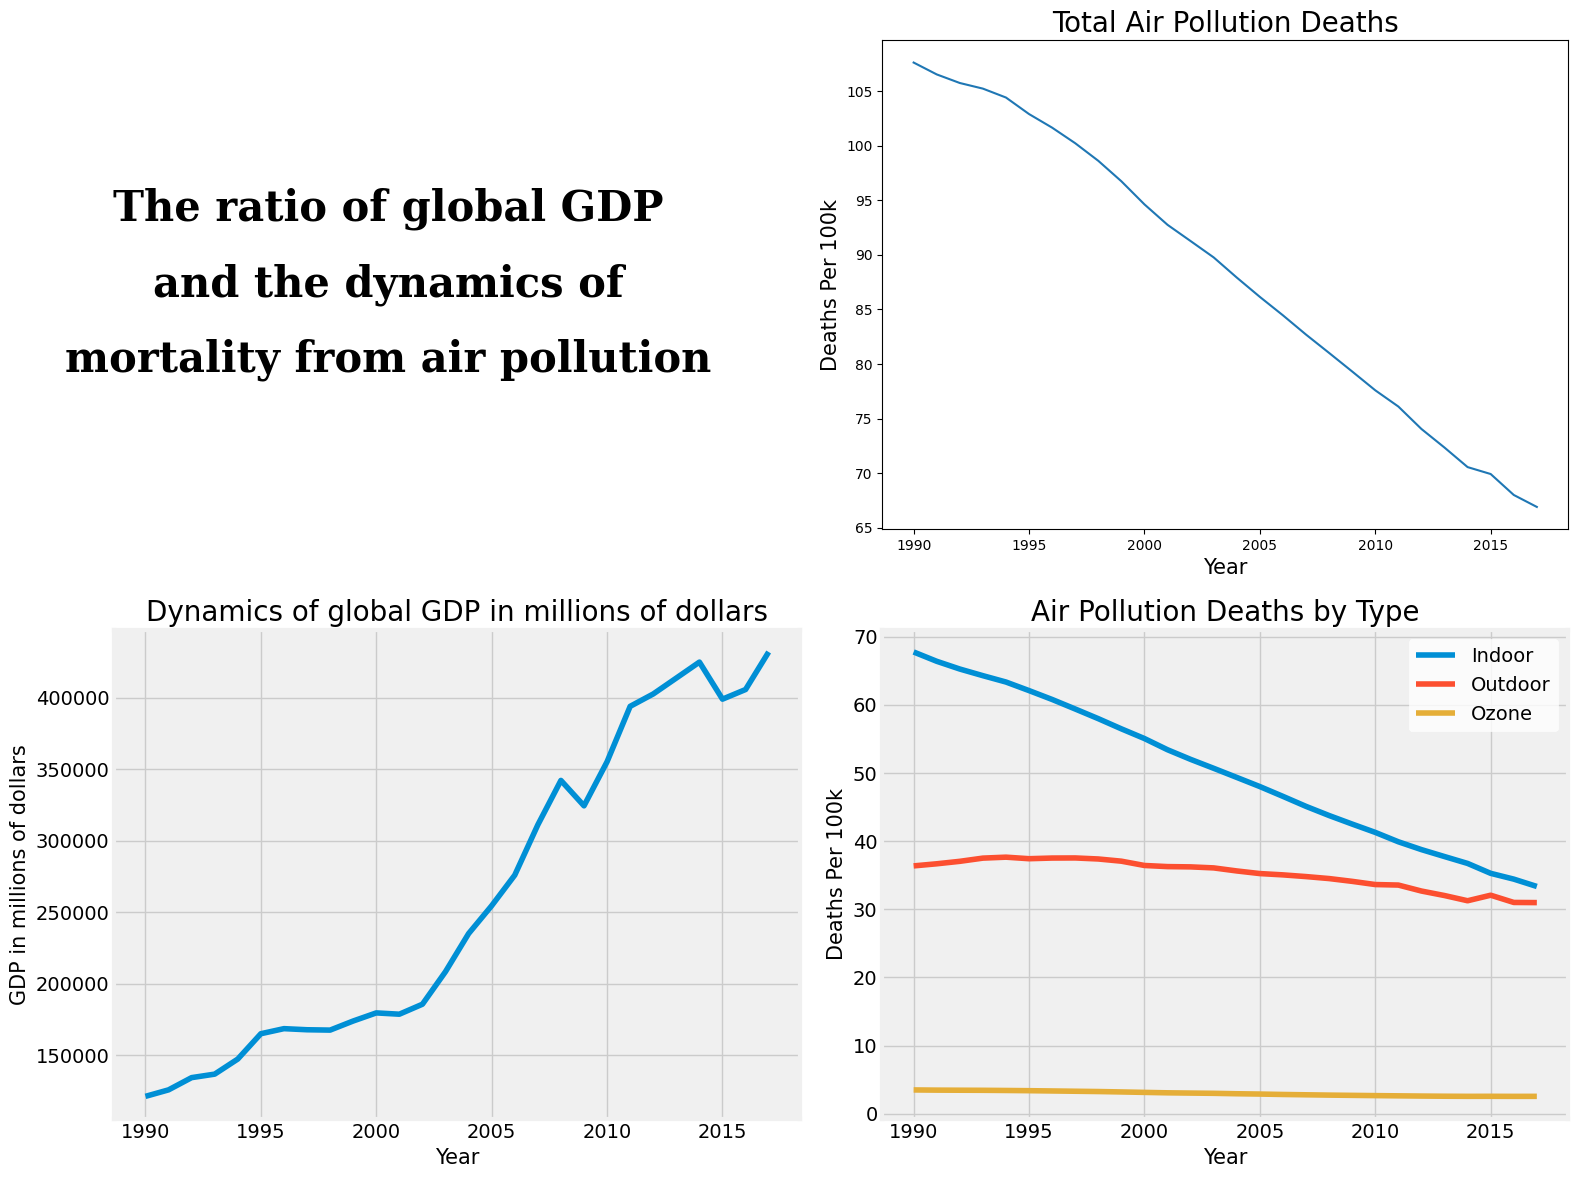

In [11]:
plt.figure(figsize=(16,12))  # Создаём участок

# Adding an overall title to the first subplot
plt.subplot(2,2,1)  # Область для первого графика
plt.axis('off')  # Запрет осей
plt.text(0.4, 0.5, 'The ratio of global GDP\nand the dynamics of\nmortality from air pollution', size=30, ha='center', va='center',
        linespacing=2, fontfamily='serif', fontweight='bold')  # Добавляем формат заголовка
plt.tight_layout()  # Указание макета для предотвращения наложения меток подзаголовка

plt.subplot(2,2,2)  # Область для первого графика
plt.plot(countries.groupby('Year')['Air pollution (total) (deaths per 100,000)'].mean())  # Создаём график
plt.xlabel('Year', size=15)  # Подписываем x-axis
plt.ylabel('Deaths Per 100k', size=15)  # Подписываем y-axis
plt.title('Total Air Pollution Deaths', size=20, fontfamily='sans-serif')  # Добавляем заголовок
plt.style.use('fivethirtyeight')  # Добавляем сетку

plt.subplot(2,2,3)  # Область для первого графика
plt.plot(countries.groupby('Year')['value, $mils'].mean())  # Создаём график
plt.xlabel('Year', size=15)  # Подписываем x-axis
plt.ylabel('GDP in millions of dollars', size=15)  # Подписываем y-axis
plt.title('Dynamics of global GDP in millions of dollars', size=20, fontfamily='sans-serif')  # Добавляем заголовок
plt.style.use('fivethirtyeight')  # Добавляем сетку


plt.subplot(2,2,4)  # Область для второго графика
plt.plot(countries.groupby('Year')['Indoor air pollution (deaths per 100,000)'].mean(), label='Indoor')  # Линия для смертности от внутреннего загрязнения
plt.plot(countries.groupby('Year')['Outdoor particulate matter (deaths per 100,000)'].mean(), label='Outdoor')  # Линия для смертности от внешнего загрязнения
plt.plot(countries.groupby('Year')['Outdoor ozone pollution (deaths per 100,000)'].mean(), label='Ozone')  # Линия для смертности от загрязнения озоном
plt.xlabel('Year', size=15)  # Подписываем x-axis
plt.ylabel('Deaths Per 100k', size=15)  # Подписываем y-axis
plt.title('Air Pollution Deaths by Type', size=20, fontfamily='sans-serif')  # Добавляем заголовок
plt.tight_layout()  # Указание макета для предотвращения наложения меток подзаголовка
legend = plt.legend(frameon=1, loc='best')  # Ддобавляем легенду
frame = legend.get_frame()
frame.set_color('white')  # Изменим фон рамки легенды
plt.style.use('fivethirtyeight')  # Добавляем сетку

Оценивая представленные графики можно сделать несколько выводов.  
-  Во-первых, с самого начала набдюдений просматривается тенденция на общемировое снижение смертности от загрязнения воздуха.  

-  Во-вторых, можно проследить зависимость падения смертности от роста ВВП. Это особенно хорошо видно в период кризиса и снижения мирового ВВП в 2015 году, что сказалось на динамики снижения смертности.  
-  В-третьих, можно сказать, что уровень смертности от загрязнения воздуха озоном практически никак не меняется.  
-  В-четвёртых, смертность от загрязнённости воздуха вне помещений твёрдыми частицами тоже имеет планомерную тенденцию к снижению и он наиболее чувствителен к росту или падению ВВП.  
-  В-пятых, смертность от загрязнений внутри помещений падает ощутимее остальных показателей смертности. И безусловно здесь сказывается развитие технологий и улучшение условий труда, условий в жилых помещениях и т.д. 

## Оценим ситуацию в нескольких отдельных странах c помощью линейной регрессии

In [12]:
lr_model = LinearRegression()  # Creating the linear regression model instance
lr_slopes = []  # Clearing the slopes list 
lr_intercepts = []  # Clearing the intercepts list
lr_scores = []  # Clearing the scores list

# Using a loop to train and test every country
for c in countries['Entity'].unique():
    X = countries[countries['Entity'] == c].iloc[:,2].values.reshape(-1,1)  # Assigning years to the 'X' variable
    y = countries[countries['Entity'] == c].iloc[:,3].values.reshape(-1,1)  # Assigning deaths to the 'y' variable
    lr_model.fit(X, y)  # Training the model
    lr_slopes.append(round(lr_model.coef_[0][0], 2))  # Adding slope to the list
    lr_intercepts.append(round(lr_model.intercept_[0], 2))  # Adding intercept to the list
    lr_scores.append(round(lr_model.score(X, y), 2))  # Adding score to the list

# Converting the lists to a dataframe
lr_countries = pd.DataFrame({'Country': countries['Entity'].unique(), 
                      'Slope': lr_slopes, 'Intercept': lr_intercepts, 'Score': lr_scores})
# Creating a new datafram of only the countries showing a positive slope
# increasing_countries = lr_countries[lr_countries['Slope'] > 0].reset_index(drop=True)
# increasing_countries
df_countries = lr_countries.sort_values(by='Slope', ascending=False).reset_index(drop=True)
df_countries.head()

,Country,Slope,Intercept,Score
0,Zimbabwe,1.93,-3730.13,0.39
1,Lesotho,1.50,-2852.13,0.52
2,Philippines,0.37,-637.24,0.22
3,Libya,0.13,-200.40,0.19
4,Uzbekistan,0.06,-8.53,0.00



Мы определили пять стран, которые демонстрируют положительный наклон и, следовательно, растущий уровень смертности из-за загрязнения воздуха. Однако оценки этих моделей снова очень низкие, поэтому нам следует визуализировать данные по странам, чтобы определить, насколько они точны.

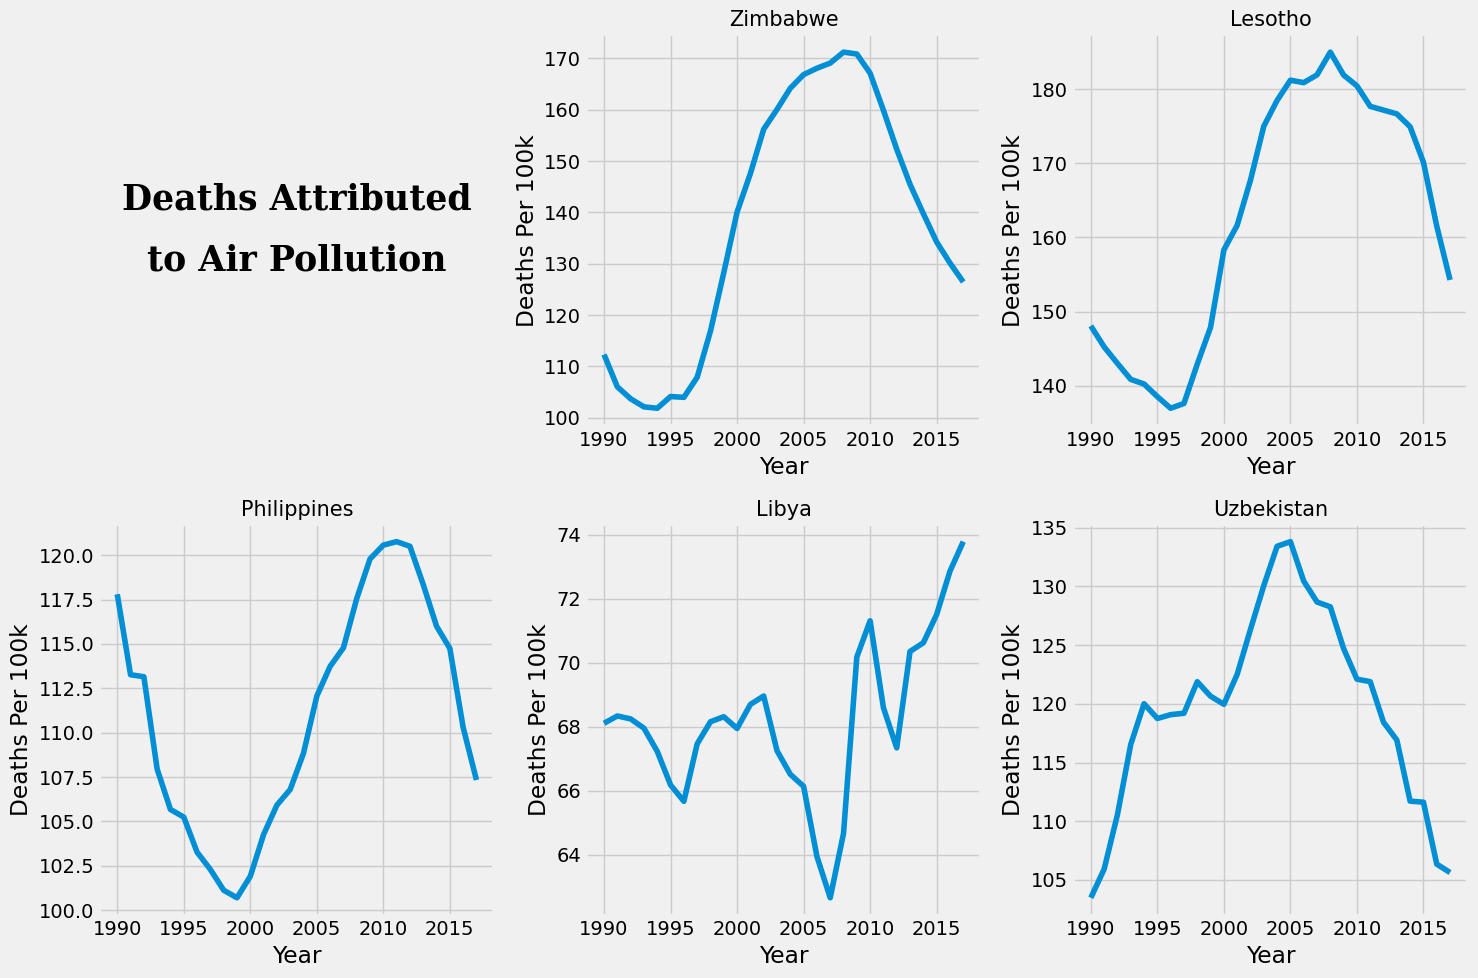

In [13]:
growing_countries = df_countries.head()

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+2)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
plt.subplot(2,3,1)  # Specifying where to place the subplot
plt.axis('off')  # Disabling the title subplot's axes
plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
        linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

Исходя из приведенных графиков видно, что данные по смертности этих стран от загрязнения воздуха имеют линейной зависимости. Что с отрицательной стороны говорит о их качестве. И, не смотря на это, даже здесь просматривается тенденция на улучшение ситуации. Исключение лишь составляет Libya, где смертность рфстёт, хот и с рваным графиком.

Сделаем выборку по странам в середине списка и средними показателями относительно мировых.

In [14]:
middle_rows = df_countries.iloc[len(df_countries)//2 - 2:len(df_countries)//2 + 3]
middle_rows

,Country,Slope,Intercept,Score
90,Ireland,-1.23,2489.45,0.98
91,Ukraine,-1.25,2589.19,0.71
92,Kenya,-1.26,2647.12,0.86
93,Singapore,-1.26,2558.16,0.99
94,Grenada,-1.28,2618.54,0.79


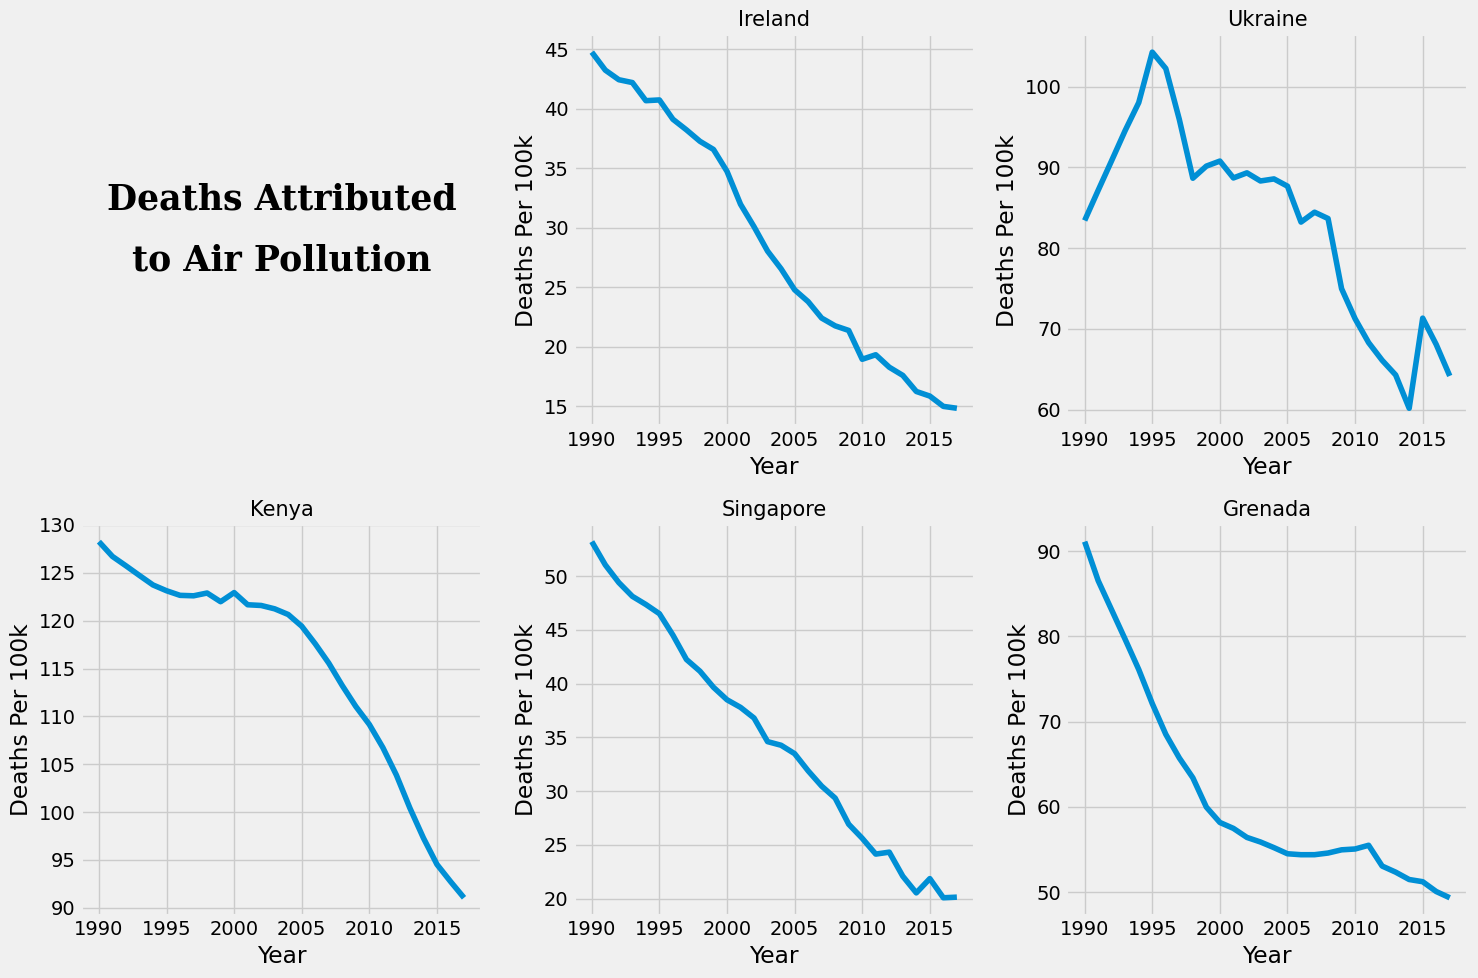

In [15]:
growing_countries = middle_rows.tail(6)

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+2)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
plt.subplot(2,3,1)  # Specifying where to place the subplot
plt.axis('off')  # Disabling the title subplot's axes
plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
        linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

В данных странах идет очевидное снижение смертности с каждым годом. Выделяется на общем фоне Ukraine с резкими перепадами, но всё же тенденция идет на снижение.

Приведем ещё один пример. Из числа тех стран, что в лидерах по снижению смертности от загрязнения воздуха.

In [16]:
df_countries.tail(6)

,Country,Slope,Intercept,Score
179,China,-4.81,9758.27,0.98
180,Maldives,-4.92,9918.81,0.96
181,Angola,-5.53,11249.90,0.99
182,Laos,-5.89,11988.71,1.00
183,Rwanda,-6.67,13532.06,0.92
184,Equatorial Guinea,-7.66,15502.92,0.91


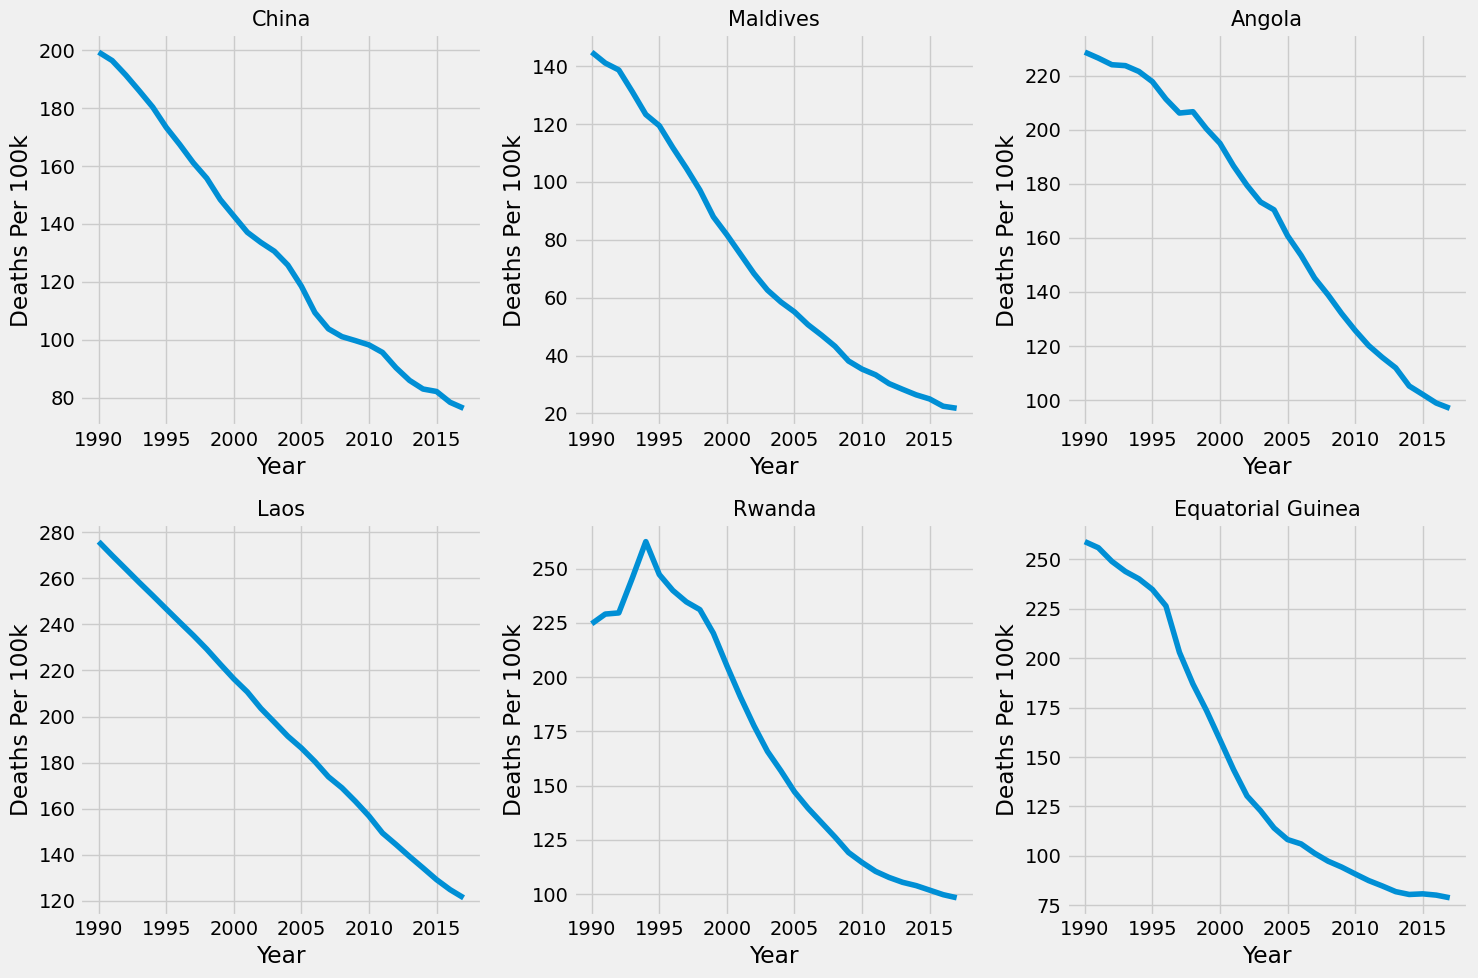

In [17]:
growing_countries = df_countries.tail(6)

plt.figure(figsize=(15,10))  # Increasing the plot size

# Using a loop to add each country's subplot
for i in range(len(growing_countries)):
    plt.subplot(2,3,i+1)  # Specifying where to place the subplot
    # Pulling the country's data from the 'countries' dataframe
    plt.plot(countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,2],
             countries[countries['Entity'] == growing_countries.iloc[i][0]].iloc[:,3])
    plt.xlabel('Year')  # Labeling the x-axis
    plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
    plt.title(growing_countries.iloc[i][0], size=15)  # Adding a title

# Adding an overall title to the first subplot
# plt.subplot(2,3,1)  # Specifying where to place the subplot
# plt.axis('off')  # Disabling the title subplot's axes
# plt.text(0.5, 0.5, 'Deaths Attributed\nto Air Pollution', size=25, ha='center', va='center',
#         linespacing=2, fontfamily='serif', fontweight='bold')  # Adding and formatting the title
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
plt.tight_layout()  # Specifying a layout to prevent overlapping subplot labels

Наюлюдается аналогичная ситуация со снижением смертности, но в гораздо большем масштабе, что не удивительно для лидирующих стран.

Используем линейную регрессию общего числа смертей во всем мире, чтобы сделать прогнозы на будущее.

In [18]:
# Assigning years to the 'X' variable and total deaths to the 'y' variable for convenience
X = countries['Year'].unique().reshape(-1,1)
y = countries.groupby('Year')['Air pollution (total) (deaths per 100,000)'].mean().values

# Calculating the index to split the data into train (80%) and test (20%) sets
split_i = int(len(y)*0.8) + 1

# Splitting the data into train and test sets
X_train = X[:split_i]
X_test = X[split_i:]
y_train = y[:split_i]
y_test = y[split_i:]

# Fitting a linear regression model on our train set
lr_model.fit(X_train, y_train)

# Calculating and displaying the model's score (R-square) against our test set
round(lr_model.score(X_test, y_test), 2)

0.83

Модель показывает относительно приличный результат - 0,83. Мы можем визуализировать это соответствие ниже.

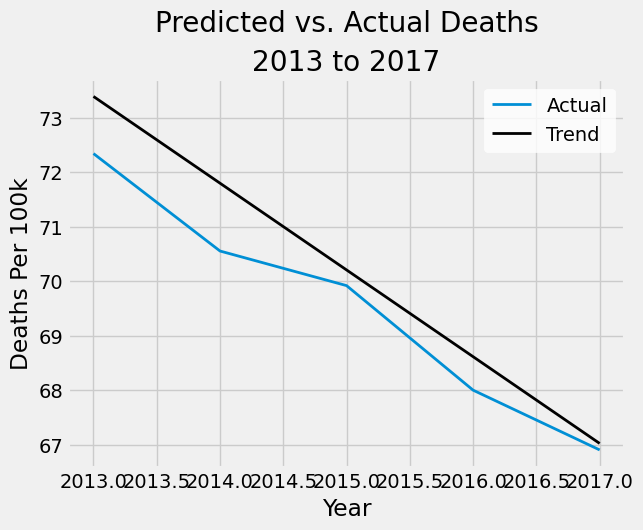

In [19]:
# Using our model to predict y-values from our test set's x-values
y_pred = lr_model.predict(X_test)

plt.plot(X_test, y_test, label='Actual', linewidth=2)  # Adding the actual deaths data to the plot
plt.plot(X_test, y_pred, label='Trend', c='black', linewidth=2)  # Adding the predicted deaths trendline to the plot
plt.title('Predicted vs. Actual Deaths\n2013 to 2017', linespacing=1.5,
         fontfamily='sans-serif')  # Adding a title
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
legend = plt.legend(frameon=1, loc='best')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

Применим модель линейной регрессии, используя набор данных, и сделаем прогнозы на будущее(набор за 2017 год, следовательно прогноз будет на 2018 и последующие года).

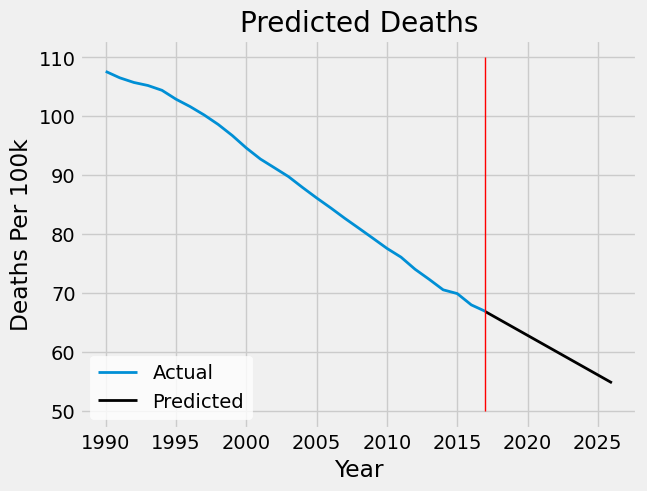

In [20]:
# Fitting the model on the entire dataset
lr_model.fit(X_test, y_test)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lr_model.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])

# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=50, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

Модель совершает прогноз в соответствии с общемировым трендом на снижение смертности и выглядит весьма правдоподобно. Можно сделать вывод, что модель хорошо отрабоатывает.

Теперь сделаем прогноз для отдельной страны и посмотрим результаты. Для примера возьмем Россию.
Приведём несколько методов прогнозирования.

## Предсказание с помощью XGBRegressor для России

In [21]:
russia_df = countries[countries['Entity'] == 'Russia']
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)']

# Нормализация признаков с помощью StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Создание модели XGBoost для регрессии
xgb = XGBRegressor()

# Определение сетки параметров для перебора (max_depth, learning_rate и т.д., можно добавить другие параметры)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}

# Использование GridSearchCV для поиска наилучших параметров модели
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров и оценки на кросс-валидации
print("Наилучшие параметры на кросс-валидации:", grid_search.best_params_)
print("Наилучшая оценка на кросс-валидации:", grid_search.best_score_)

# Прогнозирование на тестовом наборе с помощью модели с оптимальными параметрами
y_pred = grid_search.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

Наилучшие параметры на кросс-валидации: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 300}
Наилучшая оценка на кросс-валидации: -38.04029367465568
MSE на тестовом наборе:  10.117051764697555


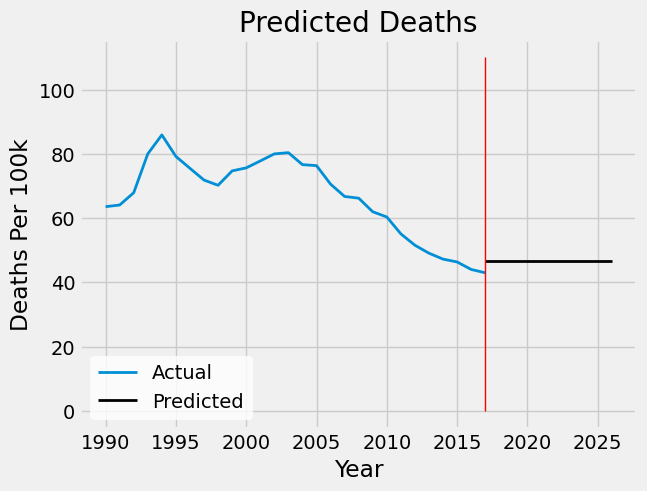

In [22]:
# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = grid_search.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

XGBRegressor показывает неплохую оценку на тестовом наборе, но на графике не прослеживается тенденция на снижение смертности как это видно из данных за предыдущие года.

# KNN for Russia

MSE на тестовом наборе:  4.067949995179376


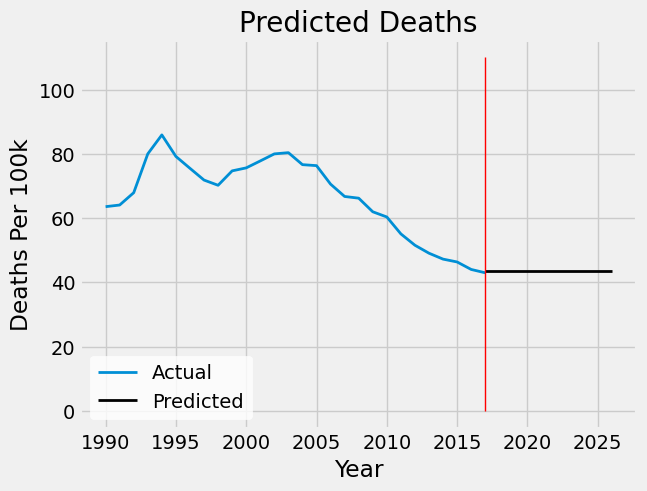

In [23]:
russia_df = countries[countries['Entity'] == 'Russia']
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определение значений параметров для подбора
param_grid = {'n_neighbors': range(1, 8)}

# Создание модели k-NN
knn = KNeighborsRegressor(metric='minkowski', p=2)

# Создание объекта GridSearchCV для подбора параметра k
grid = model_selection.GridSearchCV(knn, param_grid, cv=5)

# Обучение модели на тренировочных данных
grid.fit(X_train, y_train)

# Определение лучшего значения k
best_k = grid.best_params_['n_neighbors']

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = grid.predict(X_future)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
yy_pred = grid.predict(X_test)
mse = mean_squared_error(yy_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend


Среднеквадратичная ошибка данного метода весьма впечатляющая, но та же проблема, что и в предыдущем примере - не прослеживается тренд на снижение смертности.

# Линейная регрессия for Russia

MSE на тестовом наборе:  100.19382586250954


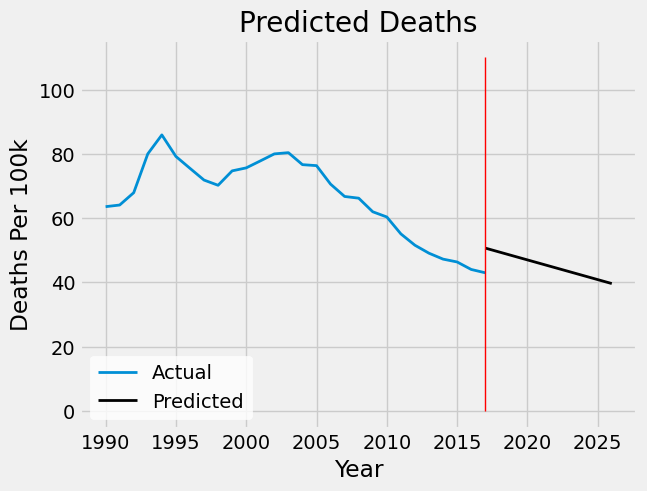

In [24]:
# Создание модели LinearRegression для регрессии
lin_reg = LinearRegression()

# Обучение модели на обучающем наборе данных
lin_reg.fit(X_train, y_train)

# Прогнозирование на тестовом наборе с помощью модели
y_pred = lin_reg.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lin_reg.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

Сократим выборку для получения более точных предсказаний

MSE на тестовом наборе:  5.823983290132854


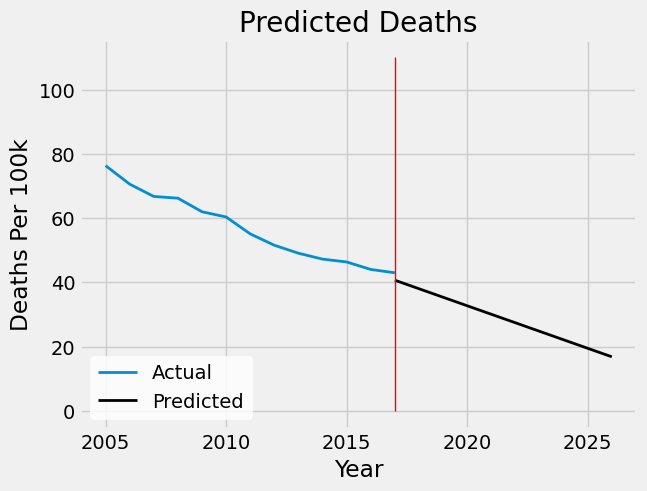

In [25]:
russia_df = countries[countries['Entity'] == 'Russia']
russia_df = russia_df[russia_df['Year'] >= 2005]
X = russia_df['Year'].array.reshape(-1,1)
y = russia_df['Air pollution (total) (deaths per 100,000)']

# Создание модели LinearRegression для регрессии
lin_reg = LinearRegression()

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели на обучающем наборе данных
lin_reg.fit(X_train, y_train)

# Прогнозирование на тестовом наборе с помощью модели
y_pred = lin_reg.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lin_reg.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

## Повышение производительности линейной регрессии
Мы можем использовать технику Boosting для оптимизации количества моделей (мы можем использовать простой поиск по сетке, поскольку у нас есть единственный гиперпараметр).

MSE на тестовом наборе:  6.342155917205427


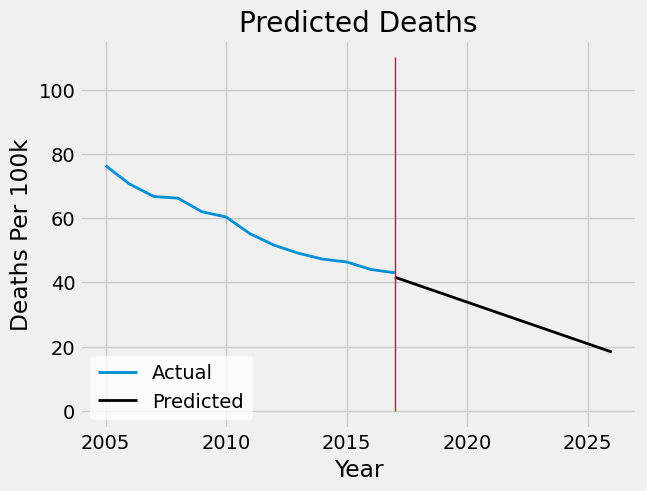

In [26]:

lr_boost = GridSearchCV(AdaBoostRegressor(LinearRegression()),
param_grid =  {
               'n_estimators':np.arange(25,1000,30)
      },
      cv=5, 
      refit=True,
      scoring="neg_mean_absolute_error")

lr_boost.fit(X_train ,y_train)

# Обучение модели на обучающем наборе данных
# lin_reg.fit(X_train, y_train)

# Прогнозирование на тестовом наборе с помощью модели
y_pred = lr_boost.predict(X_test)

# Вычисление среднеквадратической ошибки (MSE) на тестовом наборе
mse = mean_squared_error(y_pred, y_test)

# Вывод значения MSE
print("MSE на тестовом наборе: ", mse)

# Defining our x-values for the future
X_future = np.array(range(2017,2069)).reshape(-1,1)

# Predicting 50 years into the future
y_pred = lr_boost.predict(X_future)

# Converting the predictions into a dataframe
pred_df = pd.DataFrame(list(zip([x[0] for x in X_future], y_pred)), columns = ['Year', 'Prediction'])
# Plotting existing data with predictinos for the next 10 years
plt.plot(X, y, label='Actual', linewidth=2)  # Adding line for the actual deaths
plt.plot(pred_df['Year'].iloc[:10,], pred_df['Prediction'].iloc[:10,],
         c='black', label='Predicted', linewidth=2)  # Adding line for the predicted deaths
plt.vlines(x=2017, ymin=0, ymax=110, color='red', linewidths = 1)  # Adding vertical line marking the present
plt.xlabel('Year')  # Labeling the x-axis
plt.ylabel('Deaths Per 100k')  # Labeling the y-axis
plt.title('Predicted Deaths', fontfamily='sans-serif')  # Adding a title
plt.legend(loc='lower left')  # Adding the legend
plt.style.use('fivethirtyeight')  # Using a plot style to include gridlines
legend = plt.legend(frameon=1, loc='lower left')  # Adding the legend and assigning it to a variable
frame = legend.get_frame()  # Assigning the legend's frame to a variable
frame.set_color('white')  # Setting the background color of the legend

Критического улучшения небыло достигнуто. Так что можно остановиться на стандартной линейной регрессии, так как она работает быстрее и величина ошибки небольшая.